In [1]:
from astropy.cosmology import Planck18
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
import astropy.units as u
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import lalsimulation as lalsim
import numpy as np
import os.path as op
import sys
import pandas as pd
import paths
import jax.numpy as jnp
from tqdm import tqdm, trange
import weighting
import scipy.integrate as sint
import intensity_models
import fisher_snrs
#from fisher_snrs import compute_snrs
import mock_injections
from mock_injections import *
import matplotlib.pyplot as plt

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


/mnt/home/amoran/miniforge3/envs/GW_all/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-08 14:08:14.997583: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.9.86). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import jax
from importlib import reload 
reload(fisher_snrs)
jax.local_devices()
jax.config.update("jax_enable_x64", True)


In [53]:

ASD_FILES = 'sensitivity_files/aligo_O4high.txt'
PSD_FILE ='sensitivity_files/H1_o3_PSD.txt'

freqs, sens = np.loadtxt(ASD_FILES, unpack=True)
psd = sens**2 #assuming ASD here

freqs_o3, sens_03 = np.loadtxt(PSD_FILE, unpack=True)
psd_03 = sens_03 #assuming ASD here


(1e-48, 1e-36)

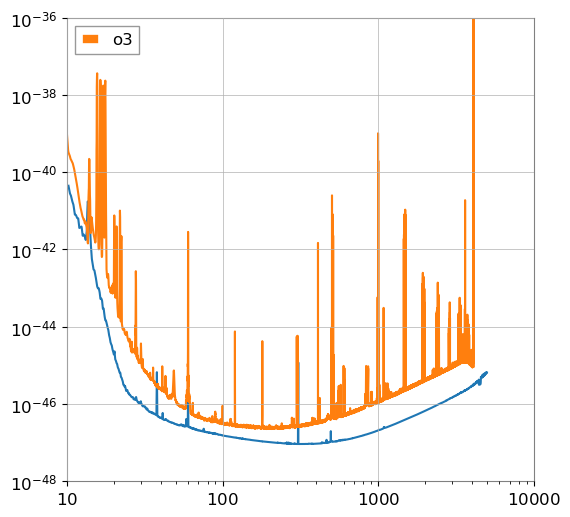

In [58]:
plt.loglog(freqs, psd)
plt.loglog(freqs_o3, psd_03, label='o3')
plt.legend()
plt.xlim(10, 10**4)
plt.ylim(1e-48, 1e-36)

### mock injections

In [28]:
SENSITIVITIES = {'aligo': lalsim.SimNoisePSDaLIGODesignSensitivityP1200087,
                'aplus': lalsim.SimNoisePSDaLIGOAPlusDesignSensitivityT1800042,
                'CE': lalsim.SimNoisePSDCosmicExplorerP1600143}

In [50]:
population_parameters = dict()
config_file = '../reproduce/configs/config2.txt'
outfile = 'mock_injections_1det2.h5'

population_parameters = dict()

with open(config_file) as param_file:
    for line in param_file:
        (key, val) = line.split('=')
        population_parameters[key.strip()] = val.strip()
        try:
            population_parameters[key.strip()] = float(val.strip())
        except ValueError:
            pass

In [51]:
snr_threshold = population_parameters.pop('snr_threshold')
ndraw = int(population_parameters.pop('ndraw', int(2e4)))
sensitivity = population_parameters.pop('sensitivity', 'aligo')
detectors = population_parameters.pop('detectors', 'H1').split(',')

custom_cosmo = intensity_models.FlatwCDMCosmology(population_parameters['h'], population_parameters['Om'], population_parameters['w'], population_parameters['zmax'])
population_parameters['cosmo'] = custom_cosmo
print("Using the following custom population_parameters: " + str(population_parameters))

Using the following custom population_parameters: {'h': 0.674, 'Om': 0.315, 'w': -1.0, 'a': 1.8, 'b': -0.71, 'c': 2.9, 'mpisn': 31.0, 'mbhmax': 36.0, 'sigma': 0.1, 'fpl': 0.21, 'lam': 3.7, 'kappa': 7.0, 'zp': 3.0, 'mpisndot': 0.0, 'zmax': 1.9, 'mbh_min': 5.0, 'delta_m': 2.5, 'beta': -1.0, 'cosmo': FlatwCDMCosmology(h=0.674, Om=0.315, w=-1.0, zmax=1.9, ninterp=1024, zinterp=Array([0.00000000e+00, 1.04131475e-03, 2.08371384e-03, ...,
       1.89396980e+00, 1.89698333e+00, 1.90000000e+00],      dtype=float64), dcinterp=Array([0.00000000e+00, 4.63057878e-03, 9.26369560e-03, ...,
       5.15257946e+00, 5.15722323e+00, 5.16186519e+00],      dtype=float64), dlinterp=Array([0.00000000e+00, 4.63540067e-03, 9.28299849e-03, ...,
       1.49114093e+01, 1.49403897e+01, 1.49694090e+01],      dtype=float64), ddlinterp=Array([4.44795252, 4.45502339, 4.46209345, ..., 9.61530365,
       9.61819823, 9.62109004], dtype=float64), vcinterp=Array([0.00000000e+00, 4.15905286e-07, 3.32997856e-06, ...,
       5

### Mock Events

In [52]:
zpdf = ZPDF(lam=population_parameters["lam"], kappa=population_parameters["kappa"], zp=population_parameters["zp"], zmax = population_parameters.get("zmax", 20), cosmo=population_parameters["cosmo"])
mpdf = PowerLawPDF(1.8, population_parameters["mbh_min"], 400)

#rng = np.random.default_rng(333165393797366967556667466879860422123)
rng = np.random.default_rng()

#df = pd.DataFrame(columns = ['m1', 'q', 'z', 'iota', 'ra', 'dec', 'psi', 'gmst', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'pdraw_mqz', 'SNR_H1', 'SNR_L1', 'SNR_V1', 'SNR'])
print("drawing zs and ms")
z = zpdf.icdf(rng.uniform(low=0, high=1, size=ndraw))
m = mpdf.icdf(rng.uniform(low=0, high=1, size=ndraw))
print("drawing mts")
mtpdf = PowerLawPDF(2, m+population_parameters['mbh_min'], 2 * m)

mt = mtpdf.icdf(rng.uniform(low=0, high=1, size=ndraw))

m2 = mt - m
q = m2/m

print("calculating pdraws")
pdraw = mpdf(m)*(mtpdf(mt)*m)*zpdf(z)

m1d = m * (1 + z)
iota = np.arccos(rng.uniform(low=-1, high=1, size=ndraw))

ra = rng.uniform(low=0, high=2*np.pi, size=ndraw)
dec = np.arcsin(rng.uniform(low=-1, high=1, size=ndraw))

# 0 < psi < pi, uniformly distributed
psi = rng.uniform(low=0, high=np.pi, size=ndraw)
gmst = rng.uniform(low=0, high=2*np.pi, size=ndraw)

print("assigning spins")

s1x, s1y, s1z = 0,0,0#rng.normal(loc=0, scale=0.2/np.sqrt(3), size=(3,ndraw))
s2x, s2y, s2z = 0,0,0#rng.normal(loc=0, scale=0.2/np.sqrt(3), size=(3,ndraw))


print("calculating dLs")

dm1sz_dm1ddl = weighting.dm1sz_dm1ddl(z, cosmo=population_parameters['cosmo'])
dL = population_parameters['cosmo'].dL(z)# dL in Gpc 
zeros=jnp.zeros(len(m))
df = {
    'm1': jnp.array(m),
    'q': jnp.array(q),
    'z': jnp.array(z),
    'dL': jnp.array(dL), #in GPC here
    'm1d': jnp.array(m1d),
    'iota': jnp.array(iota),
    'ra': jnp.array(ra),
    'dec': jnp.array(dec),
    'psi': jnp.array(psi),
    'gmst': jnp.array(gmst),
    's1x': zeros, #jnp.zeros(len(m)), 
    's1y': zeros, #jnp.zeros(len(m)), 
    's1z': zeros, #jnp.zeros(len(m)), 
    's2x': zeros, #jnp.zeros(len(m)), 
    's2y': zeros, #jnp.zeros(len(m)), 
    's2z': zeros, #jnp.zeros(len(m)), 
    'pdraw_mqz': jnp.array(pdraw),
    'dm1sz_dm1ddl': jnp.array(dm1sz_dm1ddl),
}
if snr_threshold>0:
    SNR_comp = np.zeros(ndraw)
    num_left = ndraw
    tot_num = ndraw
    batch_num=400
    num_loops=int(np.trunc(ndraw/batch_num)+1)
    for i in range(num_loops):
        if num_left==0:
            break
        start=int(tot_num - num_left)
        stop=int(tot_num - num_left + batch_num)
        if num_left > batch_num:
            df_here = {k: v[start:stop] for k, v in df.items()}
        else:
            df_here = {k: v[start:] for k, v in df.items()}
        SNR_batch = fisher_snrs.compute_snrs_batch(df_here, detectors=detectors, sensitivity=sensitivity)
        #SNR_batch = jax.device_get(SNR_batch)  # move to CPU to free GPU
        SNR_batch.block_until_ready()

        SNR_comp[start:stop]= SNR_batch
        del df_here, SNR_batch
        #jax.devices()[0].synchronize_all_streams()
        if i% 10 ==0:
            print("batch done, num left: ", num_left)
        num_left -= batch_num        
    df['SNR']=SNR_comp       
                #jnp.asarray(fisher_snrs.compute_snrs_batch(df, detectors=detectors, sensitivity=sensitivity))
        #df['SNR'] = jnp.asarray(fisher_snrs.compute_snrs(df, detectors=detectors, sensitivity=sensitivity))
        #df['SNR_old'] = jnp.asarray(fisher_snrs.compute_snrs_old(pd.DataFrame(df), detectors=detectors, sensitivity=sensitivity))
else:
    df['SNR'] = 10000000
    

df['SNR'] = SNR_comp

# Convert dict of JAX arrays -> dict of NumPy arrays
df_np = {k: np.asarray(v) for k, v in df.items()}

# Build DataFrame
df_pd = pd.DataFrame(df_np)

# now do weighting, rejection sampling, and saving
p_pop_numerator = weighting.pop_wt(df_pd['m1'].values,
                                   df_pd['q'].values,
                                   df_pd['z'].values,
                                   default=False,
                                   **population_parameters)

df_pd['p_pop_weight'] = p_pop_numerator / df_pd['pdraw_mqz'].values
df_pd['p_pop_numerator'] = p_pop_numerator

random_number = rng.uniform(low=0, high=1, size=len(p_pop_numerator))
sel = random_number < (df_pd['p_pop_weight'] / np.max(df_pd['p_pop_weight']))
population_samples = df_pd[sel]
df_det = population_samples[population_samples['SNR'] > snr_threshold]

print(f"Retained {len(df_det)} samples after rejection sampling and applying snr cut.")

df_det.to_hdf(outfile, key='true_parameters', mode='a', format='table')#, append=True)


drawing zs and ms
drawing mts
calculating pdraws
assigning spins
calculating dLs
batch done, num left:  20000
batch done, num left:  16000
batch done, num left:  12000
batch done, num left:  8000
batch done, num left:  4000
Retained 1009 samples after rejection sampling and applying snr cut.


In [18]:
#jax gives a ~40x speedum

In [35]:
df['SNR'] #jax ran in 14 seconds for 1000

array([0.37716019, 1.56049791, 0.39086196, ..., 0.27653467,
       0.60949891, 2.01755022], shape=(10000,))

In [80]:
df['SNR_old']

Array([0.02007526, 1.53290422, 0.51858167, 0.80448021,
       3.12318339, 0.38478424, 0.37885138, 0.75360569,
       1.38345391, 1.16483199], dtype=float64)

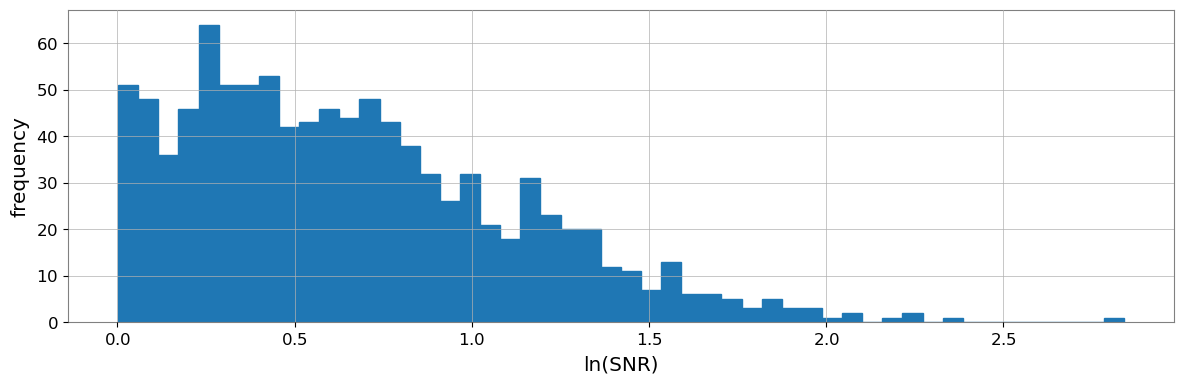

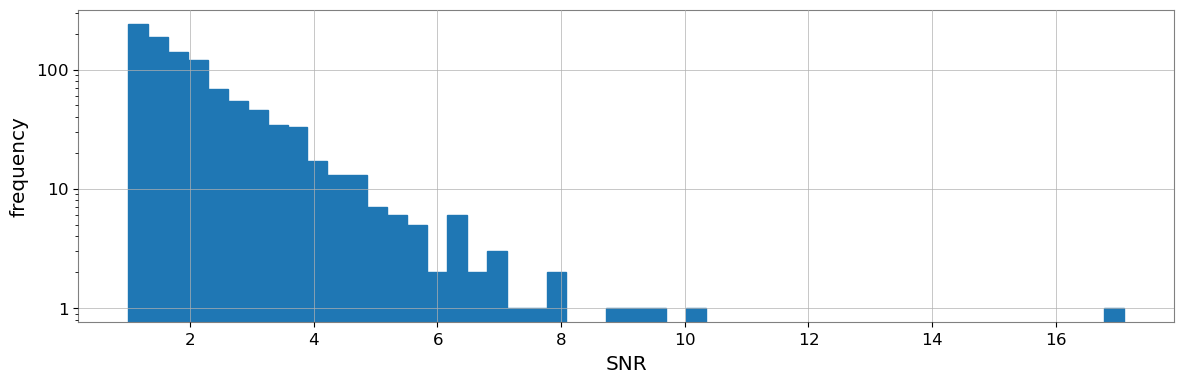

In [54]:
df_inj = pd.read_hdf("mock_injections_1det2.h5", key="true_parameters")

#first plot should somewhat match slide 8 https://dcc.ligo.org/public/0002/G0900403/002/G0900403-v2.pdf
# not as steep near 0 since we did the hopeless cut here

# Example histograms
plt.figure(figsize=(12, 4))
plt.hist(jnp.log(jnp.array(df_inj['SNR'].astype(float))), bins=50, histtype='step',  fill=True)
plt.xlabel("ln(SNR)")
plt.ylabel("frequency")
#plt.yscale('log')
#plt.xlim(0, 150)
plt.tight_layout()
plt.show()

#second plot should match https://ligo.org/wp-content/uploads/2024/04/O3Radiometer_flyer.pdf sort of (abs of that plot)

df_inj = pd.read_hdf("mock_injections_1det2.h5", key="true_parameters")

# Example histograms
plt.figure(figsize=(12, 4))
plt.hist((jnp.array(df_inj['SNR'].astype(float))), bins=50, histtype='step',  fill=True)
plt.xlabel("SNR")
plt.ylabel("frequency")
plt.yscale('log')
#plt.xlim(0, 150)
plt.tight_layout()
plt.show()


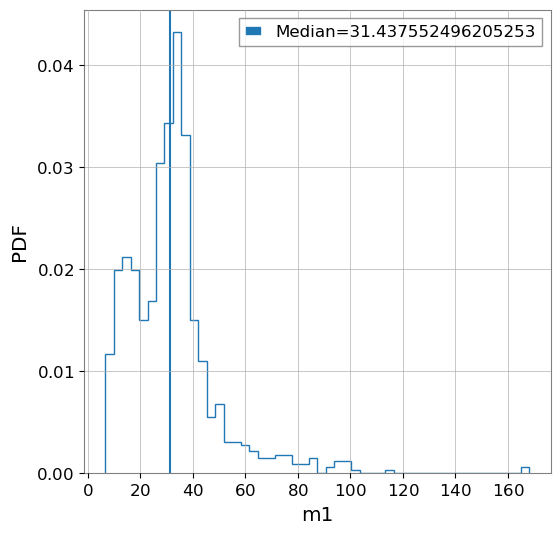

In [55]:
df_inj = pd.read_hdf("mock_injections_1det2.h5", key="true_parameters")
mass_1_inj=jnp.asarray(df_inj[['m1']]).reshape(-1)#*(1 + jnp.asarray(df_inj[['z']]).reshape(-1))
plt.hist(df_inj['m1'], bins=50, histtype='step', density=True)
mass_mean_inj=jnp.median(mass_1_inj)
plt.axvline(mass_mean_inj, label=f'Median={mass_mean_inj}')
plt.xlabel("m1")
plt.ylabel("PDF")
#plt.xlim(0, 150)
plt.legend(loc='upper right')
plt.show()


In [56]:
# check params after this step
# whats the SNR cutoff
# what numbers are we using to get uncertatinties
len(df_det)

1009

#### Checking SNR-sigma relations

In [57]:
def get_X_logmc(M, SNR, sigma_M):
    """
    Take chirp mass, SNR, and upper and lower bounds on chirp mass.
    Propogate those bounds to log chirp mass bounds
    solve for the linear factor we would use to go from SNR to sigma_log_mc
    """
    sigma_M=jnp.array(sigma_M)
    log_mc=jnp.log(M)
    sigma_log_mc=np.mean(sigma_M/M) #propogate error and collapse to symmetric errors 
    return SNR*sigma_log_mc #sigma_log_mc= X/SNR

def get_X_q(SNR, sigma_q):
    """
    solve for the linear factor we would use to go from SNR to sigma_q
    """
    sigma_q=np.mean(sigma_q) #collapse to symmetric
    return SNR*sigma_q #sigma_q= X/SNR

In [40]:
# Event data: (SNR, M, [lower_error, upper_error])
# all 35 events here: https://gwosc.org/eventapi/html/GWTC-3-confident/
events = [(4.5, 15.0, [29.5, 4.0]),
    (10.3, 8.75, [0.62, 0.55]),
    (17.8, 6.6, [2.4, 2.0]),
    (4.7, 34, [44, 18]),
    (7.8, 17.5, [3.5, 3.0]),
    (10.8, 23.4, [4.7, 3.0]),
    (12.5, 14.2, [1.5, 1.4]),
    (20.0, 31.1, [3.3, 2.7]),
    (8.5, 28.2, [7.3, 5.1]),
    (7.2, 62, [23, 15]),
    (10.7, 27.6, [5.6, 3.8]),
    (8.1, 32.9, [9.3, 8.5]),
    (8.4, 6.56, [0.38, 0.40]),
    (9.6, 26.7, [6.0, 4.2]),
    (7.4, 19.8, [10.5, 5.2]),
    (10.8, 27.7, [3.7, 3.1]),
    (10.8, 7.49, [0.24, 0.2]),
    (26.8, 27.2, [2.1, 2.3]),
    (10.6, 32.0, [7.5, 5.5]),
    (11.3, 2.43, [0.05, 0.07]),
    (19.8, 27.4, [2.6, 2.1]),
    (10.4, 36.5, [8.2, 5.6]),
    (12.5, 33.8, [7.1, 5.0]),
    (9.1, 4.31, [0.12, 0.17]),
    (18.6, 8.33, [0.22, 0.19]),
    (11.2, 18.4, [2.2, 1.7]),
    (17.4, 8.56, [0.41, 0.28]),
    (8.9, 19.8, [3.6, 3.2]),
    (13.1, 7.31, [0.43, 0.28]),
    (9.2, 29.9, [11.7, 9.1]),
    (8.3, 8.65, [0.95, 0.71]),
    (7.9, 10.7, [1.1, 1.0]),
    (17.3, 47.5, [9.6, 7.5]),
    (9.7, 7.82, [0.61, 0.45]),
    (8.9, 8.34, [0.66, 0.57])]

Xs_1 = [get_X_logmc(M, SNR, errors) for SNR, M, errors in events]

print("Mean X:", np.mean(Xs_1))
print("Std X:", np.std(Xs_1))


Mean X: 1.767974784089777
Std X: 1.3006138540035586


In [41]:
events_q= [(4.5, [0.54, 0.58]),
    (10.3, [0.27, 0.1]),
    (17.8,[.16, .2]),
    (4.7, [.58, .49]),
    (7.8, [.28, .46]),
    (10.8, [.25, .26]),
    (12.5, [.17, .28]),
    (20.0, [.15, .16]),
    (8.5, [.27, .33]),
    (7.2, [.40, .38]),
    (10.7, [.23, .29]),
    (8.1, [.34, .36]),
    (8.4, [0.22, .21]),
    (9.6, [.24, .3]),
    (7.4, [.42, .46]),
    (10.8,[ .21, .27]),
    (10.8, [.13, .06]),
    (26.8, [.11, .16]),
    (10.6, [.24, .25]),
    (11.3, [.23, .42]),
    (19.8, [.15, .15]),
    (10.4, [.26, .31]),
    (12.5, [.2, .25]),
    (9.1,[.07, .09]),
    (18.6, [0.13, .06]),
    (11.2,[.17, .21]),
    (17.4,[.08, .05]),
    (8.9,[.25, .26]),
    (13.1, [.16, .08]),
    (9.2, [.34, .36]),
    (8.3, [.15, .11]),
    (7.9, [.37, .29]),
    (17.3, [.42, .31]),
    (9.7, [.13, .09]),
    (8.9, [.16, .1])]

Xs_q = [get_X_q(SNR, errors) for SNR, errors in events_q]

print("Mean X:", np.mean(Xs_q)) # expect 1.4
print("Std X:", np.std(Xs_q))

Mean X: 2.503357142857143
Std X: 1.011096028867603


In [42]:
events_dL=[(4.5, 3500, [12500, 2200]),
(10.3, 1120, [480, 440]),
(17.8, 1170, [280, 400]),
(4.7, 7100, [13900, 4400]),
(7.8, 2100, [1700, 1100]),
(10.8, 1480, [1020, 700]),
(12.5, 1150, [510, 530]),
(20.0, 1710, [500, 650]),
(8.5, 4000, [2800, 2200]),
(7.2, 6000, [4800, 3100]),
(10.7, 3400, [1700, 1500]),
(8.1, 3800, [3000, 2000]),
(8.4, 940, [430, 340]),
(9.6, 3400, [1900, 1800]),
(7.4, 4100, [4400, 2000]),
(10.8, 2230, [1020, 850]),
(10.8, 410, [150, 160]),
(26.8, 890, [260, 370]),
(10.6, 3400, [2100, 1800]),
(11.3, 290, [150, 100]),
(19.8, 1250, [430, 460]),
(10.4, 4300, [2100, 1900]),
(12.5, 3000, [1700, 1700]),
(9.1, 550, [240, 160]),
(18.6, 340, [120, 130]),
(11.2, 1930, [890, 860]),
(17.4, 640, [200, 260]),
(8.9, 1900, [1700, 1100]),
(13.1, 790, [260, 330]),
(9.2, 3400, [3100, 1900]),
(8.3, 1620, [740, 740]),
(7.9, 1370, [1150, 620]),
(17.3, 1290, [1130, 650]),
(9.7, 1150, [430, 480]),
(8.9, 990, [500, 470])]

Xs_dL = [get_X_logmc(M, SNR, errors) for SNR, M, errors in events_dL] #error prop doesn't change, can use same formula

print("Mean X:", np.mean(Xs_dL)) # expect 4.0
print("Std X:", np.std(Xs_dL))

Mean X: 5.7244611170370865
Std X: 1.750353978079792


Also a few quick checks

In [41]:
def mc_of_m1m2(m1, m2):
    return (m1*m2)**(3/5)/((m1+m2)**(1/5))

def mc_of_qm1(q, m1):
    return m1 * q**(3/5) / (1 + q)**(1/5)

    
def mc_of_nu_Mt(nu, m1, m2 ):
    return nu**(3/5)*(m1+m2)

In [42]:
m1_test=4.863
m2_test=1.947
q_test=m2_test/m1_test
nu=q_test/((1+q_test)**2)
print(mc_of_m1m2(m1_test, m2_test))
print(mc_of_qm1(q_test,m1_test))
print(mc_of_nu_Mt(nu,m1_test,m2_test))


2.6250205659348462
2.6250205659348467
2.6250205659348462


### mock observations

In [40]:
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
import numpy as np
import os.path as op
import pandas as pd
import paths
import seaborn as sns
from tqdm import tqdm
import mock_observations
from mock_observations import *
import weighting

In [58]:
detection_threshold = 4


In [59]:
rng = np.random.default_rng(181286134409181405721219170031242732711)

inj = pd.read_hdf('mock_injections_1det2.h5', key='true_parameters')

inj['SNR_OBS'] = inj['SNR'] + rng.normal(loc=0, scale=np.sqrt(1), size=len(inj))

inj_det = inj[inj['SNR_OBS'] > detection_threshold].copy()
inj_det['mc'] = inj_det['m1'] * (inj_det['q']**(3/5) / ((1 + inj_det['q'])**(1/5)))
inj_det['dl'] = Planck18.luminosity_distance(inj_det['z'].to_numpy()).to(u.Gpc).value
inj_det['mc_det'] = inj_det['mc'] * (1 + inj_det['z'])

log_mc_obs = []
sigma_log_mc = []
q_obs = []
sigma_q = []
log_dl_obs = []
sigma_log_dl = []
for i, row in tqdm(inj_det.iterrows()):
    uncert = Uncertainties.from_snr(row['SNR_OBS'])

    log_mc_obs.append(np.log(row['mc_det']) + uncert.sigma_log_mc*rng.normal())
    sigma_log_mc.append(uncert.sigma_log_mc)

    q_jittered=row['q'] #+ uncert.sigma_q*rng.normal()
    while (q_jittered<0 or q_jittered>1.0):
        q_jittered=row['q']+ uncert.sigma_q*rng.normal()
    q_obs.append(q_jittered)
    sigma_q.append(uncert.sigma_q)

    log_dl_obs.append(np.log(row['dl']) + uncert.sigma_log_dl*rng.normal())
    sigma_log_dl.append(uncert.sigma_log_dl)

inj_det['log_mc_obs'] = log_mc_obs
inj_det['sigma_log_mc'] = sigma_log_mc
inj_det['q_obs'] = q_obs
inj_det['sigma_q'] = sigma_q
inj_det['log_dl_obs'] = log_dl_obs
inj_det['sigma_log_dl'] = sigma_log_dl
inj_det['z'] = inj_det['z']
inj_det = inj_det.reset_index(drop=True)
inj_det['evt'] = [f'evt_{i}' for i in inj_det.index]
inj_det.to_hdf('data/mock_obs_1det.h5', key='observations')

112it [00:00, 24662.01it/s]


In [60]:
df_det = pd.read_hdf("data/mock_obs_1det.h5", key="observations")
len(df_det)

112

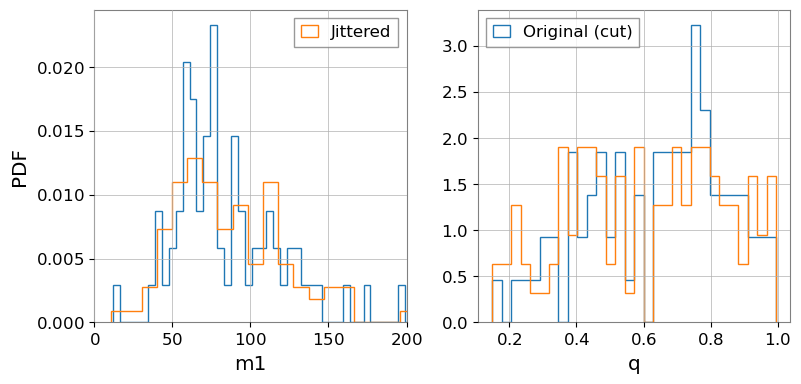

In [61]:
df_det = pd.read_hdf("data/mock_obs_1det.h5", key="observations")
df_inj = pd.read_hdf("mock_injections_1det2.h5", key="true_parameters")

df_inj_detd=df_inj[df_inj['SNR'] > detection_threshold].copy()
# Example histograms
plt.figure(figsize=(12, 4))

# Histogram of primary mass
plt.subplot(1, 3, 1)
plt.hist(df_inj_detd['m1']*(1 + df_inj_detd['z']), bins=50, histtype='step', density=True)
q_obs=df_det['q_obs']
mcs_obs = np.exp(df_det['log_mc_obs'].astype(float))
m1s_obs = mcs_obs / (q_obs**(3/5)/(1+q_obs)**(1/5))
plt.hist(m1s_obs.astype(float), bins=50, histtype='step', density=True, label='Jittered')
plt.xlabel("m1")
plt.ylabel("PDF")
plt.xlim(0, 200)
plt.legend()


# Histogram of mass ratio q
plt.subplot(1, 3, 2)
plt.hist(df_inj_detd['q'], bins=30, histtype='step', density=True, label='Original (cut)')
plt.hist(df_det['q_obs'].astype(float), bins=30, histtype='step', density=True)
plt.legend()

plt.xlabel("q")
"""
# Histogram of redshift z
plt.subplot(1, 3, 3)
plt.hist(df_inj['z'], bins=30, histtype='step', density=True)
plt.hist(df_det['z_obs'].astype(float), bins=30, histtype='step', density=True)
z_mean=np.mean(df_det['z'])
plt.axvline(z_mean, label=f'Mean={z_mean:.2f}')
plt.xlabel("z")
plt.legend()
"""
plt.tight_layout()
plt.show()


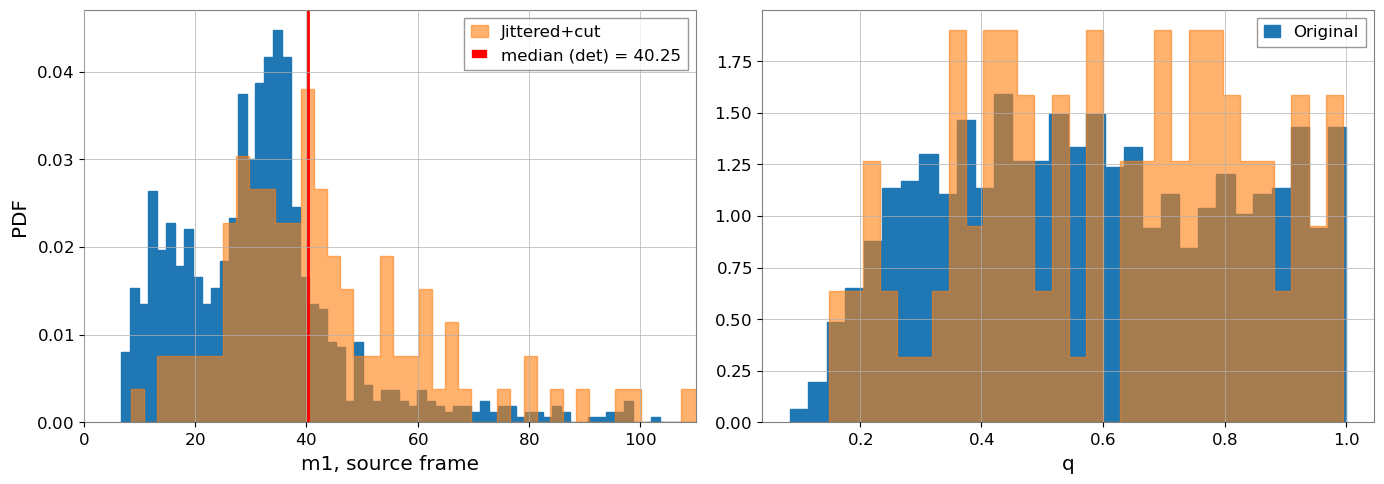

In [62]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_inj['m1'], bins=100, histtype='step',fill=True, density=True)
plt.hist(m1s_obs.astype(float)/(1+df_det['z']), bins=80, histtype='step', density=True, fill=True, alpha=.6, label='Jittered+cut')
med_detected=np.median(m1s_obs.astype(float)/(1+df_det['z']))
plt.axvline(med_detected, color='red', label=f'median (det) = {med_detected:.2f}', linewidth=2)
plt.xlabel("m1, source frame")
plt.ylabel("PDF")
plt.xlim(0,110)
plt.legend()

plt.subplot(1,2, 2)
plt.hist(df_inj['q'], bins=30, histtype='step', density=True, fill=True, label='Original')
plt.hist(df_det['q_obs'].astype(float), bins=30, histtype='step',fill=True, alpha=0.6, density=True)
plt.legend()

plt.xlabel("q")
plt.tight_layout()
plt.show()


In [63]:
pe_samples_full = pd.read_hdf('../src/data/mock_obs_1det.h5', 'observations')


nsamples = 200  # number of draws per event
m1s, qs, dls, pdraws = [], [], [], []

for n, e in pe_samples_full.groupby('evt'):
    # preallocate arrays for this event
    m1_event = []
    q_event = []
    dl_event = []
    pdraw_event = []

    for num in range(nsamples):
        samples = weighting.draw_mock_samples(
            e['log_mc_obs'].iloc[0],  # detector frame
            e['sigma_log_mc'].iloc[0],
            e['q_obs'].iloc[0],
            e['sigma_q'].iloc[0],
            e['log_dl_obs'].iloc[0],
            e['sigma_log_dl'].iloc[0])
        m1_event.append(samples[0][0])
        q_event.append(samples[1][0])
        dl_event.append(samples[2][0])
        pdraw_event.append(samples[3][0])

    # store all samples for this event
    m1s.append(m1_event)
    qs.append(q_event)
    dls.append(dl_event)
    pdraws.append(pdraw_event)

# convert to arrays (shape = nevents × nsamples)
m1s = np.array(m1s)
qs = np.array(qs)
dls = np.array(dls)
pdraws = np.array(pdraws)

print("array shapes (we want nevents, nsamples): ", m1s.shape, qs.shape, dls.shape, pdraws.shape)

array shapes (we want nevents, nsamples):  (112, 200) (112, 200) (112, 200) (112, 200)


In [64]:
df_samples = pd.DataFrame({
    'm1': list(m1s),       # each element is an array of nsamples
    'q': list(qs),
    'dl': list(dls),
    'pdraw': list(pdraws)
})
df_samples.to_hdf("pe_samp_mock1det.hdf5", key="samples", mode="w")

/tmp/ipykernel_203870/3051582669.py:7: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['m1', 'q', 'dl', 'pdraw'], dtype='object')]

  df_samples.to_hdf("pe_samp_mock1det.hdf5", key="samples", mode="w")


### Generate selection samples

In [65]:
import weighting

In [66]:
import gc
gc.collect()

39599

In [7]:
from importlib import reload 
reload(weighting)
reload(fisher_snrs)

<module 'fisher_snrs' from '/mnt/home/amoran/GW_stuff/src/fisher_snrs.py'>

In [8]:
#('/home/reed.essick/rates+pop/o3-sensitivity-estimates/LIGO-T2100113-v11/endo3_bbhpop-LIGO-T2100113-v11.hdf5', nsamp=None, desired_pop_wt=None)
m1, q, z, a1, a2, cos_tilt1, cos_tilt2, pdraw, ndraw = weighting.sel_samples_mock('../endo3_bbhpop-LIGO-T2100113-v12.hdf5',
                                                                                  detectors=detectors, SNR=4, sensitivity='aligo')

df = pd.DataFrame({'m1': m1, 'q': q, 'z': z, 'a1': a1, 'a2':a2, 'cos_tilt_1': cos_tilt1, 'cos_tilt_2': cos_tilt2, 'pdraw_m1sqz': pdraw, 'ndraw': ndraw}) 



In [9]:
df['dm1sz_dm1ddl'] = weighting.dm1sz_dm1ddl(df['z']) #gives us factor to go soruce to detector frame mass, and z to dL in prior
df.to_hdf('./selection_samples.h5', 'samples')

/tmp/ipykernel_1691915/1308923982.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf('./selection_samples.h5', 'samples')


In [48]:
snr_net = np.loadtxt('LIGO_SNR.txt')
len(np.where(snr_net>4)[0])

212307

In [44]:
df_out = pd.read_hdf("./selection_samples.h5", key="samples")
len(df_out)
df_out.keys()

Index(['m1', 'q', 'z', 'a1', 'a2', 'cos_tilt_1', 'cos_tilt_2', 'pdraw_m1sqz',
       'ndraw', 'dm1sz_dm1ddl'],
      dtype='object')

In [12]:
212307/284672

0.7457951607464028

In [87]:
tot_samples=284672

71.168

In [15]:
import h5py


In [24]:
with h5py.File('../endo3_bbhpop-LIGO-T2100113-v12.hdf5', 'r') as f:
    SNRs=jnp.array(f['injections/optimal_snr_h'])

In [50]:
len(np.where(SNRs>4)[0])

215033

In [51]:
215033/284672

0.75537109375

In [49]:
212307/284672

0.7457951607464028